## 导语

上节课我们已经了解到了KMeans是一个非常不错的聚类算法，但是对于如下几种场景的数据，它却不能很好的完成聚类：
![dWH9aT.md.png](https://s1.ax1x.com/2020/08/26/dWH9aT.md.png)

## 层次聚类（Hierarchical Clustering）

层次聚类同样也是基于距离的算法，只不过考虑的是【点与点】之间的距离，如下图所示，我们把距离最近的点放到一起，然后逐级生长，得到**系统树图（DENDROGRAM）**。
![dWbAk8.md.png](https://s1.ax1x.com/2020/08/26/dWbAk8.md.png)

之后，再根据我们想要的分类数量，从根部逐级拆分即可。如，我们想要分成两类，那么就可以把第一级（黄色线）拆掉，得到A类（3，4，5，1，2）和B类（6，8，7）。

从上面的过程可以看出，层次聚类的关键是**点之间距离的计算**，那就可以根据不同的计算方法，把该算法进行分类。


### single-link单链接

在单链接方法中，计算点之间距离考虑的是：
- 单点：点与点之间最近的距离
- 组与组：如果是两个分组的话（如3和（4，5）），也只考虑分组中最近的两个点之间的距离（即考虑3与4之间的距离，作为两个分组的距离）

如下图所示，是single-link与Kmeans之间的对比：
![dWqPgJ.md.png](https://s1.ax1x.com/2020/08/26/dWqPgJ.md.png)

除了在个别数据集中的优化之外，使用层次聚类还有一个优势，就是系统树图的可视化，可以帮助我们很方便的对四维及以上的数据集进行可视化，如下图所示：
![dWLGQJ.md.png](https://s1.ax1x.com/2020/08/26/dWLGQJ.md.png)

### complete-link 全链接
- 先假设所有的点都单独成类，自下往上进行聚类
- 先把距离最近的点合并成类
- 【与single-link区别】在计算类与类之间的距离时，考虑的是**最远的距离**

对于相同的数据集，其分类变成了下图所示（注意3的分组）

![dWOH3D.md.png](https://s1.ax1x.com/2020/08/26/dWOH3D.md.png)

这样生成的类会比single-link更加紧凑，效果也会更好。

### average-link 平均链接
不管是single-link还是complete-link，都只关注单点，一旦最近（或最远）的点确定以后，就不会再考虑其他点了，这样有可能会造成偏见。

平均链接即考虑两组间，所有点两两之间的距离的平均值。（显而易见的，这里的计算量非常高）

### ward‘s method 离差平方和
这种算法的目的是把合并类时的变量最小化，它的计算过程可以简述为：
- 计算两类中各点与两类中心点的距离
- 分别计算两类各点与各自中心点的距离
- 第一步减去第二步的结果，即为距离

如下图所示：
![dWjneA.md.png](https://s1.ax1x.com/2020/08/26/dWjneA.md.png)

### 在Sklearn中的应用

In [1]:
from sklearn import datasets,cluster
X = datasets.load_iris().data[:10]
clust = cluster.AgglomerativeClustering(n_clusters=3,linkage='ward')

/Users/daiziyue/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/daiziyue/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
labels = clust.fit_predict(X)

/Users/daiziyue/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
labels

array([1, 0, 0, 0, 1, 2, 0, 1, 0, 0])

#### 绘制系统树图


In [4]:
from scipy.cluster.hierarchy import dendrogram, ward, single
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
# 拟合数据
linkage_matrix = ward(X)

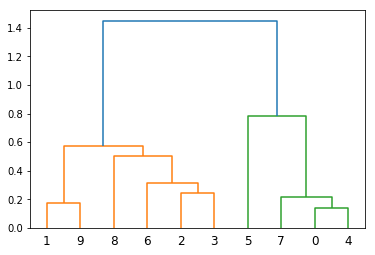

In [7]:
# 绘制
dendrogram(linkage_matrix);

### 优缺点及应用

优点：
- 得到非常形象具体的数据层次表达
- 对于本身存在层次关系的数据非常有效（比如生物学中的物种）

缺点：
- 对噪点和离群值非常敏感
- 计算量很大（$O(N^{2})$)

应用：
- Paper: [Using Hierarchical Clustering of Secreted Protein Families to Classify and Rank Candidate Effectors of Rust Fungi](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0029847)

- Paper: [Association between composition of the human gastrointestinal microbiome and development of fatty liver with choline deficiency](https://www.ncbi.nlm.nih.gov/pubmed/21129376)


## 密度聚类（DBSCAN）

DBSCAN，全称Density-Based Spatial Clustering of Applications with Noise，也就是具有噪声的基于密度的聚类方法。它会把分布相对密集，距离较近的点聚集到一起，而那些完全离散的点会被认作为“噪声”。


![d5aSZq.md.png](https://s1.ax1x.com/2020/08/27/d5aSZq.md.png)
如上图所示，该算法的执行过程可以简述为：
- 先随机选择一个点，然后以该点为中心，检测以$\epsilon $（图示中Epsilon=1）为半径的范围内，是否存在一定数量（MinPts）的其他点；
- 如果有的话，则把该点标记为类的中心点（图示中的红色和绿色）；
- 如果没有的话，那就继续检测其附近的点：
    - 如果附近的点也不满足要求，那么就把这些点标记为噪声（图示中灰色的点）；
    - 若附近点满足要求，则把该点标记为类的边界点（图示中黄色的点）

>可以从这个在线可视化中，了解DBSCAN的执行过程：https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/

跟KMeans的对比：
![d5ao6J.md.png](https://s1.ax1x.com/2020/08/27/d5ao6J.md.png)

### 在Sklearn中的应用

In [39]:
db = cluster.DBSCAN(eps=0.5,min_samples=5)#这里只需要设置距离及最少样本数，DBSCAN会自动计算出分类数量
db.fit(X)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=None, p=None)

In [40]:
db.labels_

array([ 0,  0,  0,  0,  0, -1,  0,  0,  0,  0])

在`labels_`中，-1表示离群值，其余则表示分类。

### 优缺点及应用

优点：
- 我们不需要规定类目的数量
- 可以灵活地找到并分离不同形状和大小的类
- 对噪声及离群值具有非常高的检测性

缺点：
- 类的边界点可能会被分到两个类中，因为DBSCAN检测点时是随机的，而且没有回溯机制，但这种情况很少见；
- 很难找到不同密度的类，可以用优化算法HDBSCAN去解决此类问题。


> - [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html)
> - [Sklearn Clustering](https://scikit-learn.org/stable/modules/clustering.html)

应用：
- Paper: 【推荐，非常完整的非监督分类思考&执行过程】网络流量分类[Traffic Classification Using Clustering Algorithms](https://pages.cpsc.ucalgary.ca/~mahanti/papers/clustering.pdf)

- Paper: 温度数据的异常检测[Anomaly detection in temperature data using dbscan algorithm](https://ieeexplore.ieee.org/abstract/document/5946052/)
